In [1]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import warnings
import random

In [2]:
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler
from collections import Counter
from imblearn.over_sampling import SMOTE

import shap

/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
warnings.filterwarnings("ignore")
plt.style.use('tableau-colorblind10')

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

In [5]:
# Reading Train data
full_train_data = pl.read_csv("../data/merged_cleaned_insurance_data.csv")

In [6]:
full_train_data = (
    full_train_data
    .group_by(["Provider", "PotentialFraud"])
    .agg([
        pl.col("*").exclude(["Provider", "PotentialFraud"]).sum()
    ])
)

In [7]:
X = full_train_data.drop(['Provider', 'PotentialFraud'])

y = full_train_data.select('PotentialFraud')

X_shape = X.shape
y_shape = y.shape
X_type = type(X)
y_type = type(y)

print(X_shape, X_type)
print(y_shape, y_type)

(5410, 63) <class 'polars.dataframe.frame.DataFrame'>
(5410, 1) <class 'polars.dataframe.frame.DataFrame'>


In [8]:
X_pd = X.to_pandas()
y_pd = y.to_pandas().squeeze()

X_train, X_test, y_train, y_test = train_test_split(
    X_pd, y_pd,
    test_size=0.20,
    stratify=y_pd,
    random_state=39
)


print("SHAPES:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

print("\nTARGET DISTRIBUTION IN y_train:")
print(y_train.value_counts())

print("\nTARGET DISTRIBUTION IN y_test:")
print(y_test.value_counts())

SHAPES:
X_train: (4328, 63)
X_test: (1082, 63)
y_train: (4328,)
y_test: (1082,)

TARGET DISTRIBUTION IN y_train:
PotentialFraud
0    3923
1     405
Name: count, dtype: int64

TARGET DISTRIBUTION IN y_test:
PotentialFraud
0    981
1    101
Name: count, dtype: int64


In [9]:
robust_scaler = RobustScaler()
X_train_std = robust_scaler.fit_transform(X_train)
X_test_std = robust_scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)

In [10]:
counter = Counter(y_train)
print("Before SMOTE:", counter)

smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_ovsamp, y_train_ovsamp = smote.fit_resample(X_train_std, y_train)

counter_after = Counter(y_train_ovsamp)
print("After SMOTE:", counter_after)

Before SMOTE: Counter({0: 3923, 1: 405})
After SMOTE: Counter({0: 3923, 1: 3923})


In [11]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_ovsamp, y_train_ovsamp,
    test_size=0.15, stratify=y_train_ovsamp, random_state=SEED
)

In [12]:
def get_loader(X, y, batch_size, shuffle=True):
    x_tensor = torch.from_numpy(X.values).float()
    y_tensor = torch.from_numpy(y.values).float().unsqueeze(1)
    dataset = TensorDataset(x_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = get_loader(X_train_split, y_train_split, batch_size=256)
val_loader = get_loader(X_val, y_val, batch_size=512, shuffle=False)
test_loader = get_loader(X_test_std, y_test, batch_size=512, shuffle=False)

In [13]:
class DeepNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        dims = [input_dim, 512, 256, 128, 64, 32, 16, 8, 4, 1]
        layers = []

        for i in range(len(dims)-2):
            layers.extend([
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.ReLU(),
                nn.Dropout(p=0.3 if i < 4 else 0.1)
            ])
        
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepNet(X_train_split.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 100

In [15]:
summary(model, input_size=(X_train_split.shape[1],))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       32,768
|    └─BatchNorm1d: 2-2                  1,024
|    └─ReLU: 2-3                         --
|    └─Dropout: 2-4                      --
|    └─Linear: 2-5                       131,328
|    └─BatchNorm1d: 2-6                  512
|    └─ReLU: 2-7                         --
|    └─Dropout: 2-8                      --
|    └─Linear: 2-9                       32,896
|    └─BatchNorm1d: 2-10                 256
|    └─ReLU: 2-11                        --
|    └─Dropout: 2-12                     --
|    └─Linear: 2-13                      8,256
|    └─BatchNorm1d: 2-14                 128
|    └─ReLU: 2-15                        --
|    └─Dropout: 2-16                     --
|    └─Linear: 2-17                      2,080
|    └─BatchNorm1d: 2-18                 64
|    └─ReLU: 2-19                        --
|    └─Dropout: 2-20                     --
| 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       32,768
|    └─BatchNorm1d: 2-2                  1,024
|    └─ReLU: 2-3                         --
|    └─Dropout: 2-4                      --
|    └─Linear: 2-5                       131,328
|    └─BatchNorm1d: 2-6                  512
|    └─ReLU: 2-7                         --
|    └─Dropout: 2-8                      --
|    └─Linear: 2-9                       32,896
|    └─BatchNorm1d: 2-10                 256
|    └─ReLU: 2-11                        --
|    └─Dropout: 2-12                     --
|    └─Linear: 2-13                      8,256
|    └─BatchNorm1d: 2-14                 128
|    └─ReLU: 2-15                        --
|    └─Dropout: 2-16                     --
|    └─Linear: 2-17                      2,080
|    └─BatchNorm1d: 2-18                 64
|    └─ReLU: 2-19                        --
|    └─Dropout: 2-20                     --
| 

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"⏹️ Early stopping triggered after {self.counter} checks.")
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [17]:
early_stopper = EarlyStopping(patience=5, min_delta=1e-4)

train_loss_history = []
val_auc_history = []
val_f1_history = []
val_acc_history = []


for epoch in range(epochs):
    model.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            outputs = model(X_val_batch)
            val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            val_targets.extend(y_val_batch.squeeze().numpy())

    val_preds_binary = [1 if p > 0.5 else 0 for p in val_preds]
    acc = accuracy_score(val_targets, val_preds_binary)
    auc = roc_auc_score(val_targets, val_preds)
    f1 = f1_score(val_targets, val_preds_binary)

    train_loss = sum(train_losses) / len(train_losses)
    train_loss_history.append(train_loss)
    val_auc_history.append(auc)
    val_f1_history.append(f1)
    val_acc_history.append(acc)

    print(f"Epoch {epoch+1:02d} - Loss: {sum(train_losses)/len(train_losses):.4f} | Val AUC: {auc:.4f} | F1: {f1:.4f}")

    early_stopper(auc)
    if early_stopper.early_stop:
        break

Epoch 01 - Loss: 0.6644 | Val AUC: 0.9259 | F1: 0.6663
Epoch 02 - Loss: 0.5828 | Val AUC: 0.9254 | F1: 0.8691
Epoch 03 - Loss: 0.5276 | Val AUC: 0.9424 | F1: 0.8727
Epoch 04 - Loss: 0.4971 | Val AUC: 0.9428 | F1: 0.8724
Epoch 05 - Loss: 0.4776 | Val AUC: 0.9412 | F1: 0.8630
Epoch 06 - Loss: 0.4572 | Val AUC: 0.9419 | F1: 0.8705
Epoch 07 - Loss: 0.4398 | Val AUC: 0.9487 | F1: 0.8804
Epoch 08 - Loss: 0.4201 | Val AUC: 0.9482 | F1: 0.8855
Epoch 09 - Loss: 0.4120 | Val AUC: 0.9476 | F1: 0.8859
Epoch 10 - Loss: 0.4006 | Val AUC: 0.9489 | F1: 0.8823
Epoch 11 - Loss: 0.3880 | Val AUC: 0.9496 | F1: 0.8838
Epoch 12 - Loss: 0.3935 | Val AUC: 0.9524 | F1: 0.8809
Epoch 13 - Loss: 0.3834 | Val AUC: 0.9518 | F1: 0.8797
Epoch 14 - Loss: 0.3727 | Val AUC: 0.9518 | F1: 0.8857
Epoch 15 - Loss: 0.3943 | Val AUC: 0.9530 | F1: 0.8905
Epoch 16 - Loss: 0.3751 | Val AUC: 0.9513 | F1: 0.8833
Epoch 17 - Loss: 0.3659 | Val AUC: 0.9535 | F1: 0.8691
Epoch 18 - Loss: 0.3544 | Val AUC: 0.9534 | F1: 0.8930
Epoch 19 -

In [18]:
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        test_preds.extend(torch.sigmoid(outputs).cpu().numpy())
        test_targets.extend(y_batch.squeeze().numpy())

test_preds_binary = [1 if p > 0.5 else 0 for p in test_preds]

In [19]:
print("\nFinal Test Evaluation:")
print("Accuracy:", accuracy_score(test_targets, test_preds_binary))
print("AUC:", roc_auc_score(test_targets, test_preds))
print("F1 Score:", f1_score(test_targets, test_preds_binary))


Final Test Evaluation:
Accuracy: 0.7939001848428835
AUC: 0.9275340378074506
F1 Score: 0.45742092457420924


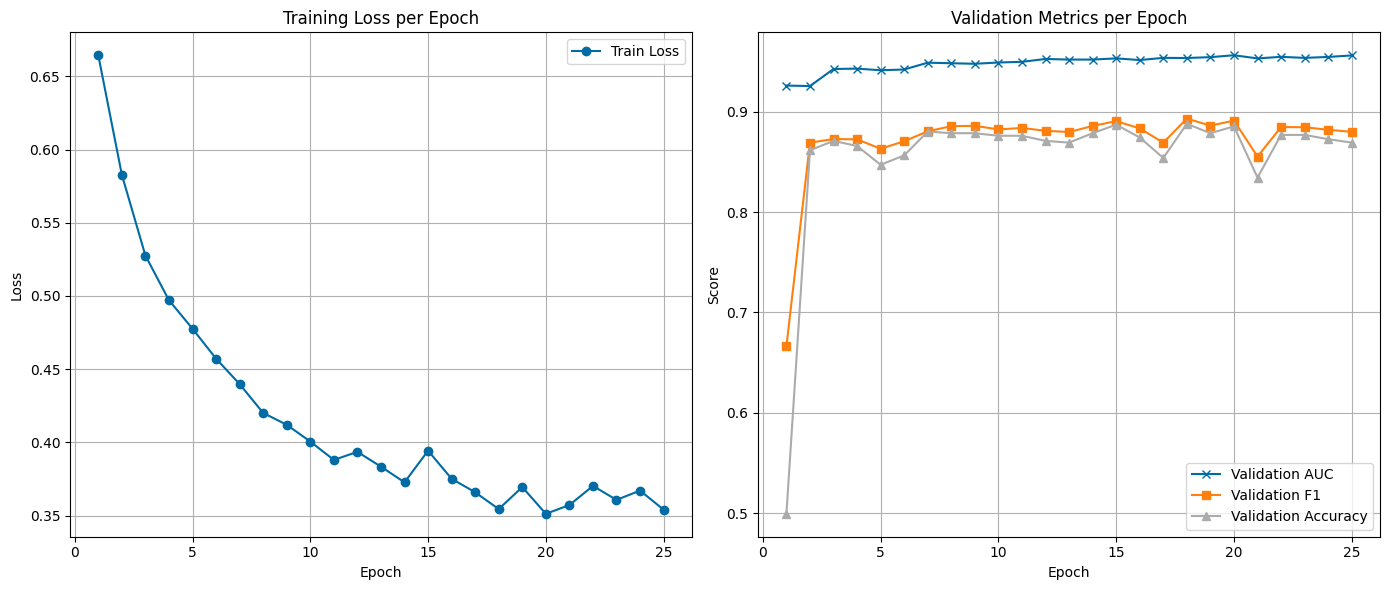

In [20]:
epochs_range = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss', marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_auc_history, label='Validation AUC', marker='x')
plt.plot(epochs_range, val_f1_history, label='Validation F1', marker='s')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy', marker='^')
plt.title("Validation Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()